## 1. Importと定数定義

In [50]:
import torch
from torchvision import transforms, datasets
from torchvision.models.resnet import BasicBlock, resnet18
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import wandb
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [51]:
BATCH_SIZE = 512
LR = 1e-3
MIN_LR = 1e-4
NUM_WORKERS = 8
EPOCHS = 50

## 2. Datasetsを読み込む

In [52]:
# 学習用データセット
train_datasets = datasets.CIFAR10(
    "data/",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),        
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(degrees=45),    
        transforms.RandomApply(
            p=0.3,
            transforms=[
                transforms.ColorJitter(),
            ]
        ),  
        transforms.Normalize(
            mean=[0.43146829, 0.43438266, 0.40927926],
            std=[0.03874232, 0.04122919, 0.04268689],
        ),
        transforms.Resize(64),
    ])
)
# 検証用データセット
val_datasets = datasets.CIFAR10(
    "data/",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),        
        transforms.Normalize(
            mean=[0.43146829, 0.43438266, 0.40927926],
            std=[0.03874232, 0.04122919, 0.04268689],
        ),
        transforms.Resize(64),
    ])
)

Files already downloaded and verified
Files already downloaded and verified


## 3. Modelの用意

In [53]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)             
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.pooling1 = nn.MaxPool2d((3, 3), stride=2, padding=1)
        self.layer1 = BasicBlock(
            64,
            64,
        )
        self.layer2 = nn.Sequential(
            BasicBlock(
                64,
                128,
                downsample=nn.Conv2d(64, 128, kernel_size=1, stride=2),
                stride=2,
            ),
        )
        self.layer3 = nn.Sequential(            
            BasicBlock(
                128,
                256,
                downsample=nn.Conv2d(128, 256, kernel_size=1, stride=2),
                stride=2,
            ),
        )
        self.layer4 = nn.Sequential(            
            BasicBlock(
                256,
                1024,
                downsample=nn.Conv2d(256, 1024, kernel_size=1, stride=2),
                stride=2
            ),
        )
        self.fc1 = nn.Linear(
            1024,
            128,
        )
        self.fc2 = nn.Linear(
            128,
            10,
        )
        self.activation = nn.LogSoftmax(dim=1)
        
    def forward(self, x: torch.Tensor):
        x = self.conv(x)
        x = self.pooling1(x)
        x = self.layer1(x)
        x = self.layer2(x)        
        x = self.layer3(x)
        x = self.layer4(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        out = self.activation(x)
        return out

### ネットワークの確認（任意）
今回MNISTは28×28pxなので同様の形状でネットワークに入力をして、出力が(BATCH_SIZE, 10)の形状のテンソルであることを確認する

In [54]:
input_image, input_label = val_datasets[40]
input_image.shape

torch.Size([3, 64, 64])

In [55]:
input_label = torch.tensor([input_label])

In [56]:
imgs = input_image.unsqueeze(dim=0)
labels = input_label.unsqueeze(dim=0)
model = Model()
outs = model(imgs)
outs

tensor([[-2.4348, -2.0996, -2.3835, -2.4109, -2.7042, -2.0657, -2.6325, -2.3177,
         -2.0988, -2.1098]], grad_fn=<LogSoftmaxBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


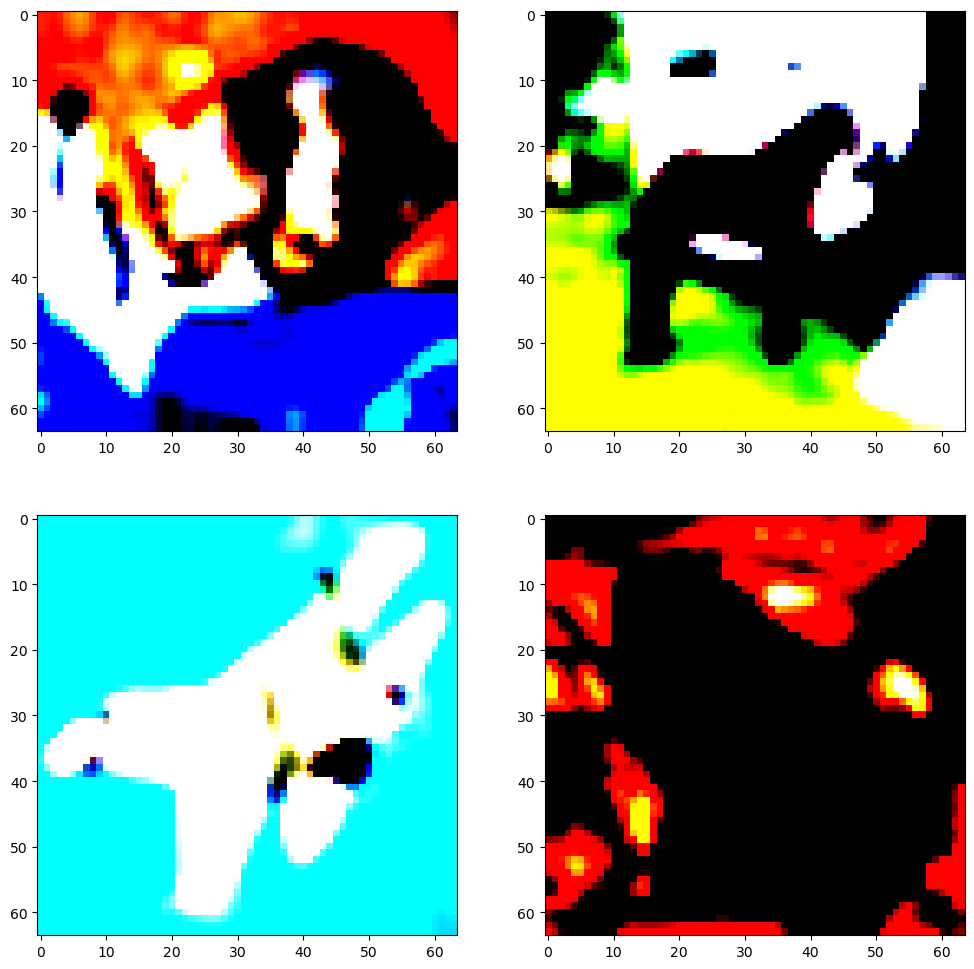

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for i in range(2):
    for j in range(2):
        axes[i][j].imshow(val_datasets[10 * (i + j * 2)][0].permute(1, 2, 0).numpy())

## 4.学習 & 検証

### 学習に必要な要素の準備

In [58]:
# デバイス
device = torch.device("cuda")

# 深層学習モデル
model = Model()
model = nn.DataParallel(model)
model = model.to(device)

# 損失関数
loss_fn = nn.NLLLoss() # nn.LogSoftmax + nn.NLLLoss == 交差クロスエントロピー

# 最適化関数
optimizer = optim.Adam(model.parameters(), lr=LR)

# 学習率スケジューラ
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,
    eta_min=MIN_LR,
)

# データローダ
# 学習用
train_dataloader = DataLoader(
    train_datasets,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)
# 検証用
val_dataloader = DataLoader(
    val_datasets,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
)

### 学習 & 検証

In [59]:
results = [
    {
        "train": {},
        "val": {}
    } for i in range(EPOCHS)
]

In [60]:
for epoch in tqdm(range(EPOCHS)):
    model.train()
    epoch_loss = 0
    correct_counts = 0
    for imgs, labels in tqdm(train_dataloader, leave=False):        
        optimizer.zero_grad()
        imgs = imgs.to(device)
        labels = labels.to(device)
        outs = model(imgs)
        loss = loss_fn(outs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()    
        preds = torch.argmax(outs, dim=1)
        correct_counts += (preds == labels).sum().item()
    lr_scheduler.step()
    acc = correct_counts / len(train_datasets)
    epoch_loss = epoch_loss / len(train_datasets)
    print(f"epoch: {epoch}, train loss: {epoch_loss:.3f}. train acc: {acc:.3f}")
    results[epoch]["train"]["acc"] = acc
    results[epoch]["train"]["loss"] = epoch_loss
    with torch.no_grad():
        model.eval()
        correct_counts = 0
        for imgs, labels in tqdm(val_dataloader, leave=False):
            imgs = imgs.to(device)
            labels = labels.to(device)
            outs = model(imgs)
            preds = torch.argmax(outs, dim=1)
            correct_counts += (preds == labels).sum().item()
        acc = correct_counts / len(val_datasets)
        print(f"epoch: {epoch}, val acc: {acc:.3f}")
        results[epoch]["val"]["acc"] = acc

  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 0, train loss: 0.003. train acc: 0.396


  2%|▏         | 1/50 [00:09<07:26,  9.11s/it]

epoch: 0, val acc: 0.493


epoch: 1, train loss: 0.003. train acc: 0.518


  4%|▍         | 2/50 [00:18<07:14,  9.05s/it]

epoch: 1, val acc: 0.587


epoch: 2, train loss: 0.002. train acc: 0.570


  6%|▌         | 3/50 [00:27<07:06,  9.07s/it]

epoch: 2, val acc: 0.612


epoch: 3, train loss: 0.002. train acc: 0.612


  8%|▊         | 4/50 [00:36<07:00,  9.14s/it]

epoch: 3, val acc: 0.660


epoch: 4, train loss: 0.002. train acc: 0.647


 10%|█         | 5/50 [00:45<06:50,  9.12s/it]

epoch: 4, val acc: 0.672


epoch: 5, train loss: 0.002. train acc: 0.664


 12%|█▏        | 6/50 [00:54<06:40,  9.10s/it]

epoch: 5, val acc: 0.694


epoch: 6, train loss: 0.002. train acc: 0.685


 14%|█▍        | 7/50 [01:03<06:33,  9.14s/it]

epoch: 6, val acc: 0.710


epoch: 7, train loss: 0.002. train acc: 0.700


 16%|█▌        | 8/50 [01:13<06:24,  9.16s/it]

epoch: 7, val acc: 0.698


epoch: 8, train loss: 0.002. train acc: 0.714


 18%|█▊        | 9/50 [01:22<06:14,  9.14s/it]

epoch: 8, val acc: 0.738


epoch: 9, train loss: 0.002. train acc: 0.729


 20%|██        | 10/50 [01:31<06:05,  9.15s/it]

epoch: 9, val acc: 0.724


epoch: 10, train loss: 0.001. train acc: 0.738


 22%|██▏       | 11/50 [01:40<05:56,  9.13s/it]

epoch: 10, val acc: 0.756


epoch: 11, train loss: 0.001. train acc: 0.745


 24%|██▍       | 12/50 [01:49<05:46,  9.11s/it]

epoch: 11, val acc: 0.717


epoch: 12, train loss: 0.001. train acc: 0.756


 26%|██▌       | 13/50 [01:58<05:36,  9.10s/it]

epoch: 12, val acc: 0.760


epoch: 13, train loss: 0.001. train acc: 0.763


 28%|██▊       | 14/50 [02:07<05:27,  9.11s/it]

epoch: 13, val acc: 0.769


epoch: 14, train loss: 0.001. train acc: 0.773


 30%|███       | 15/50 [02:16<05:18,  9.11s/it]

epoch: 14, val acc: 0.766


epoch: 15, train loss: 0.001. train acc: 0.778


 32%|███▏      | 16/50 [02:25<05:09,  9.10s/it]

epoch: 15, val acc: 0.775


epoch: 16, train loss: 0.001. train acc: 0.784


 34%|███▍      | 17/50 [02:34<04:59,  9.08s/it]

epoch: 16, val acc: 0.772


epoch: 17, train loss: 0.001. train acc: 0.794


 36%|███▌      | 18/50 [02:43<04:50,  9.09s/it]

epoch: 17, val acc: 0.784


epoch: 18, train loss: 0.001. train acc: 0.802


 38%|███▊      | 19/50 [02:53<04:41,  9.09s/it]

epoch: 18, val acc: 0.791


epoch: 19, train loss: 0.001. train acc: 0.809


# 5.可視化

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


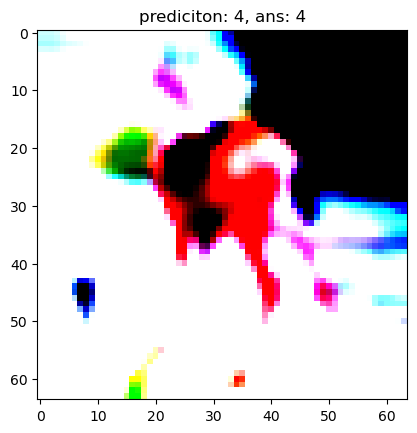

In [ ]:
img, label = val_datasets[100]
outs = model(img.unsqueeze(dim=0))

predict_label = torch.argmax(outs, dim=1)[0].item()
img = img.permute((1, 2, 0)).numpy()
plt.imshow(img, cmap="gray")
plt.title(f"prediciton: {predict_label}, ans: {label}")
plt.show()

In [ ]:
train_acc = []
train_loss = []
val_acc = []
for result in results:
    train_acc.append(result["train"]["acc"])
    train_loss.append(result["train"]["loss"])
    val_acc.append(result["val"]["acc"])

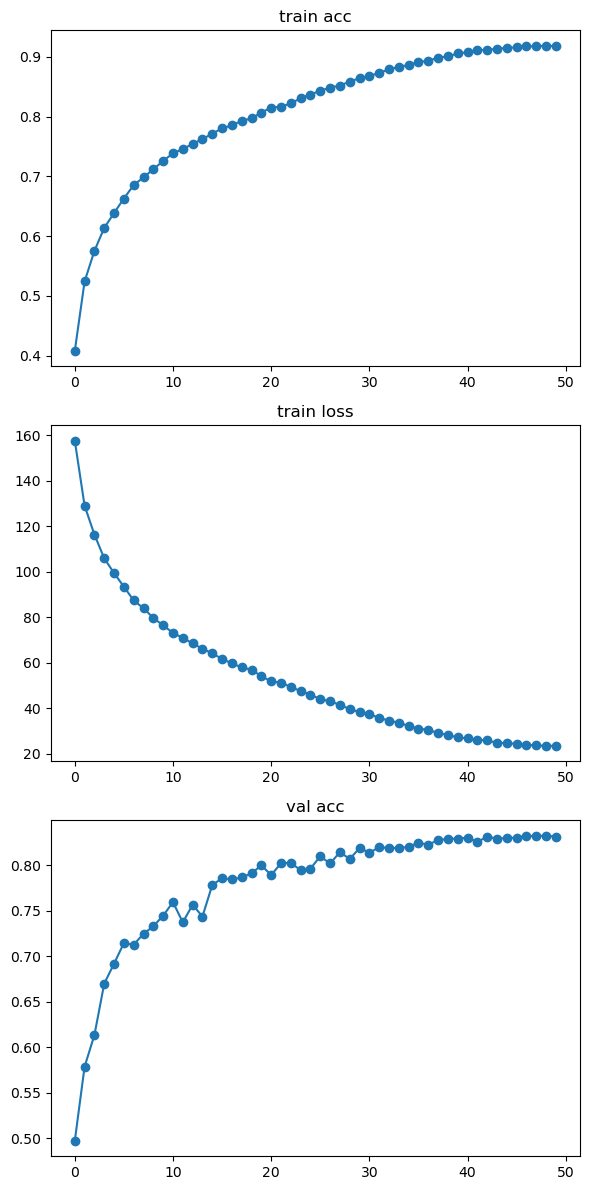

In [ ]:
x = np.array(range(EPOCHS))
fig, axes = plt.subplots(3, 1, figsize=(6, 12))

axes[0].plot(x, train_acc, marker="o")
axes[0].set_title("train acc")
axes[1].plot(x, train_loss, marker="o")
axes[1].set_title("train loss")
axes[2].plot(x, val_acc, marker="o")
axes[2].set_title("val acc")
fig.tight_layout()
fig.show()